<a href="https://colab.research.google.com/github/rocabrera/language-uncertainty/blob/master/exploring_experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experiments results

This notebook has the goal to explore the results generated by the finetuned model. We did two experiments:

- Bucketing uncertainty in three classes: low, medium and high;
- Using real value for uncertainty


We will explore these results as following:

- Share some good examples, where the model did well
- Share some bad examples, where the model did bad
- Calculate the accuracy per bucket (we will discretize our real distribution for the one we returned values)
- Loss curve during training and results on training dataset, to show we had more room to train

In [1]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import seaborn as sns
sns.set(font_scale=1.05)

import matplotlib.pyplot as plt
plt.style.use("ggplot")

## 1. Using real values for uncertainty

In [3]:
df_train_results = pd.read_csv('/content/drive/MyDrive/UNICAMP/squadshifts_aggregated_not_bucket_with_predictions_train.csv')
df_test_results = pd.read_csv('/content/drive/MyDrive/UNICAMP/squadshifts_aggregated_not_bucket_with_predictions_test.csv')

In [4]:
def split_uncertainty(df: pd.DataFrame):
  def convert_to_float(uncertainty: str):
    try:
      uncertainty = float(uncertainty)
    except:
      uncertainty = None
    return uncertainty

  df['predicted_uncertainty'] = df['predict_after_finetunning'].\
                                  apply(lambda x: x.split('Uncertainty: ')[-1] if 'Uncertainty' in x else None)
  df['target_uncertainty'] = 1 - df['mean_f1']
  df['predicted_uncertainty'] = df['predicted_uncertainty'].apply(convert_to_float)
  old_shape = df.shape
  df.dropna(subset=['predicted_uncertainty'], inplace=True)
  new_shape = df.shape
  print(f'After dropna, goes from {old_shape[0]} rows to {new_shape[0]} rows.')
  print(f'Lost {1 - (new_shape[0]/old_shape[0])}% of lines')
  df['diff'] = np.abs(df['predicted_uncertainty'] - df['target_uncertainty'])

In [5]:
split_uncertainty(df_train_results)

After dropna, goes from 6712 rows to 6122 rows.
Lost 0.08790226460071515% of lines


In [6]:
split_uncertainty(df_test_results)

After dropna, goes from 584 rows to 525 rows.
Lost 0.10102739726027399% of lines


In [7]:
def create_buckets(df: pd.DataFrame):
  df['target_bucket'] = 'low'
  df['predicted_bucket'] = 'low'
  df.loc[df['target_uncertainty'] >= 0.33, 'target_bucket'] = 'medium'
  df.loc[df['target_uncertainty'] >= 0.66, 'target_bucket'] = 'high'
  df.loc[df['predicted_uncertainty'] >= 0.33, 'predicted_bucket'] = 'medium'
  df.loc[df['predicted_uncertainty'] >= 0.66, 'predicted_bucket'] = 'high'

In [8]:
create_buckets(df_train_results)
create_buckets(df_test_results)

In [9]:
df_train_results['target_bucket'].value_counts(normalize=True)

low       0.575629
high      0.236524
medium    0.187847
Name: target_bucket, dtype: float64

In [10]:
aux = (df_test_results.groupby('target_bucket')['predicted_bucket']
                      .value_counts(normalize=True)
                      .mul(100)
                      .rename('Percent')
                      .reset_index()
                      .rename(columns={"predicted_bucket": "Predicted Bucket",
                                       "target_bucket": "Target Bucket"})
)
aux

,Target Bucket,Predicted Bucket,Percent
0,high,low,49.624060
1,high,high,48.872180
2,high,medium,1.503759
3,low,low,63.345196
4,low,high,36.298932
5,low,medium,0.355872
6,medium,low,52.252252
7,medium,high,47.747748


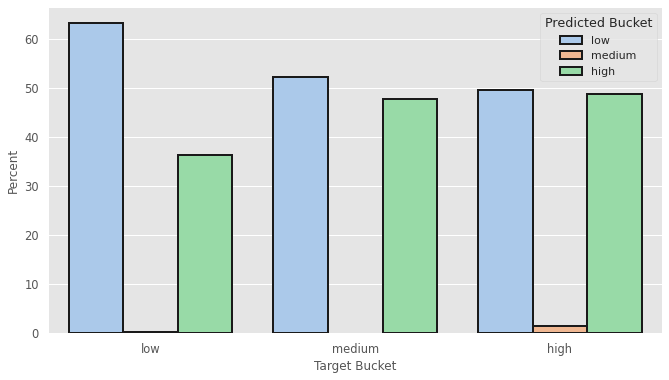

In [11]:
fig, ax = plt.subplots(figsize = (11,6))
sns.barplot(data=aux, 
            x="Target Bucket", 
            y="Percent", 
            hue="Predicted Bucket",
            linewidth=2,
            edgecolor="k",
            order=["low", "medium", "high"],
            hue_order=["low", "medium", "high"],
            palette="pastel",
            ax=ax)

plt.legend(loc="upper right", fontsize=11, title="Predicted Bucket")
plt.savefig("/content/not_bucket_results.png", format="png")
plt.show()

In [12]:
aux = df_test_results.rename(columns={"predicted_bucket": "Predicted Bucket", "target_bucket": "Target Bucket"})
predict_bucket_accuracy = pd.crosstab(aux["Target Bucket"], aux["Predicted Bucket"], dropna=False, normalize="index").round(3).mul(100)
predict_bucket_accuracy.columns = pd.Index(['low', 'medium', 'high'], dtype='object', name='Predicted Bucket')
predict_bucket_accuracy.index = pd.Index(['low', 'medium', 'high'], dtype='object', name='Target Bucket')
predict_bucket_accuracy.applymap(lambda x: str(round(x,3))+"%")

Predicted Bucket,low,medium,high
Target Bucket,,,
low,48.9%,49.6%,1.5%
medium,36.3%,63.3%,0.4%
high,47.7%,52.3%,0.0%


# **Iteractive Figures**

In [13]:
fig = go.Figure()

fig.add_trace(go.Bar(x=['low', 'medium', 'high'], y=[0.633452, 0.522523, 0.496241], name='predicted low'))
fig.add_trace(go.Bar(x=['low', 'medium', 'high'], y=[0.003559, 0., 0.015038], name='predicted medium'))
fig.add_trace(go.Bar(x=['low', 'medium', 'high'], y=[0.362989, 0.477477, 0.488722], name='predicted high'))
fig.show()

In [14]:
fig = go.Figure()

fig.add_trace(go.Bar(x=['low', 'medium', 'high'], y=[0.575629, 0.187847, 0.236524]))
fig.show()

In [15]:
df_train_results['predict_len'] = df_train_results['predict_after_finetunning'].apply(len)
df_train_results.groupby(['target_bucket'])['predict_len'].mean()

target_bucket
high      35.908840
low       34.661180
medium    41.076522
Name: predict_len, dtype: float64

In [16]:
df_test_results['predict_len'] = df_test_results['predict_after_finetunning'].apply(len)
df_test_results.groupby(['target_bucket', 'predicted_bucket'])['predict_len'].mean()

target_bucket  predicted_bucket
high           high                41.523077
               low                 28.439394
               medium              87.500000
low            high                42.549020
               low                 28.556180
               medium              86.000000
medium         high                41.169811
               low                 30.431034
Name: predict_len, dtype: float64

In [17]:
df_test_results.query('target_bucket=="high" and predicted_bucket=="high" and predicted_uncertainty!=1')[['context', 'question', 'first_answer', 'predict_after_finetunning']]

,context,question,first_answer,predict_after_finetunning
3,Tin is generated via the long S-process in low...,how is tin made?,long S-process in low-to-medium mass stars Unc...,via the long S-process Uncertainty: 0.83
6,Unemployment can be measured in several ways. ...,How many United States citizens make up the ci...,157.8 million Uncertainty: 0.83,approximately 157.8 million Uncertainty: 0.83
10,Whereas first-wave feminism focused mainly on ...,What major ammendment did feminism attempt to ...,Equal Rights Amendment (ERA) to the United Sta...,Equal Rights Amendment (ERA) Uncertainty: 0.83
25,Tin is a chemical element with the symbol Sn (...,How many isotopes does Tin have?,10 stable isotopes Uncertainty: 0.83,10 stable isotopes Uncertainty: 0.83
43,"Throughout its history, Pitt has been committe...",What opportunities for experience does Pitt of...,co-ops and internships Uncertainty: 0.79,co-ops and internships Uncertainty: 0.83
...,...,...,...,...
560,Throughout ancient and medieval history most a...,How frequent were advances in buildings?,seldom Uncertainty: 1.0,seldom Uncertainty: 0.83
561,When stack-based procedure calls were first in...,What does the stack contain?,the private data of the calls that are current...,only the private data of the calls that are cu...
564,Vote tallies and seat counts in parentheses ab...,Were there clear winners in the election in We...,most Senate votes cast in Western Australia we...,"returned 3 Liberal, 1 Labor, 1 Green, 1 Palmer..."
574,Window glass is most often made by floating mo...,What is the process of creating float glass ca...,Pilkington process Uncertainty: 0.94,"the ""Pilkington process"" Uncertainty: 0.83"


In [18]:
df_test_results.query('target_bucket=="low" and predicted_bucket=="low"')[['context', 'question', 'first_answer', 'predict_after_finetunning']].iloc[[5, 8]]

,context,question,first_answer,predict_after_finetunning
18,Various studies and surveys indicate that home...,How many attacks against homeless people were ...,109 Uncertainty: 0.0,109 Uncertainty: 0.0
26,Two of the Seven Sister colleges made transiti...,What is Radcliffe now known as?,Radcliffe Institute for Advanced Study in Wome...,Radcliffe Institute for Advanced Study in Wome...


In [19]:
df_test_results['target_uncertainty'] = df_test_results['target_uncertainty'].apply(lambda x: round(x, 2))

In [20]:
df_test_results[['context', 'question', 'target_uncertainty', 'predict_after_finetunning']].loc[[3, 18, 26, 145]]

,context,question,target_uncertainty,predict_after_finetunning
3,Tin is generated via the long S-process in low...,how is tin made?,0.69,via the long S-process Uncertainty: 0.83
18,Various studies and surveys indicate that home...,How many attacks against homeless people were ...,0.00,109 Uncertainty: 0.0
26,Two of the Seven Sister colleges made transiti...,What is Radcliffe now known as?,0.00,Radcliffe Institute for Advanced Study in Wome...
145,"When those from Japan, Taiwan and Hong Kong wr...",What might have been a reason for the Samis no...,0.88,Surnames have been imposed by the dominant aut...


## 2. Bucketing uncertainty

In [21]:
df_train_results = pd.read_csv('/content/drive/MyDrive/UNICAMP/squadshifts_aggregated_bucket_with_predictions_train.csv')
df_test_results = pd.read_csv('/content/drive/MyDrive/UNICAMP/squadshifts_aggregated_bucket_with_predictions_test.csv')

In [22]:
def split_uncertainty(df: pd.DataFrame):
  def convert_to_bucket(bucket: str):
    if bucket in ['low', 'medium', 'high']:
      return bucket
    return None

  df['predicted_uncertainty'] = df['predict_after_finetunning'].\
                                  apply(lambda x: x.split('Uncertainty: ')[-1] if 'Uncertainty' in x else None)
  df['target_uncertainty'] = df['bucket_uncertainty']
  df['predicted_uncertainty'] = df['predicted_uncertainty'].apply(convert_to_bucket)
  old_shape = df.shape
  df.dropna(subset=['predicted_uncertainty'], inplace=True)
  new_shape = df.shape
  print(f'After dropna, goes from {old_shape[0]} rows to {new_shape[0]} rows.')
  print(f'Lost {1 - (new_shape[0]/old_shape[0])}% of lines')

In [23]:
split_uncertainty(df_train_results)

After dropna, goes from 6712 rows to 6125 rows.
Lost 0.08745530393325385% of lines


In [24]:
split_uncertainty(df_test_results)

After dropna, goes from 584 rows to 530 rows.
Lost 0.09246575342465757% of lines


In [25]:
df_train_results['target_uncertainty'].value_counts(normalize=True)

low       0.574041
high      0.237061
medium    0.188898
Name: target_uncertainty, dtype: float64

In [26]:
aux = (df_test_results.groupby('target_uncertainty')['predicted_uncertainty']
                      .value_counts(normalize=True)
                      .mul(100)
                      .rename('Percent')
                      .reset_index()
                      .rename(columns={"predicted_uncertainty": "Predicted Bucket",
                                       "target_uncertainty": "Target Bucket"})
)
aux

,Target Bucket,Predicted Bucket,Percent
0,high,low,88.235294
1,high,medium,8.088235
2,high,high,3.676471
3,low,low,98.214286
4,low,medium,1.071429
5,low,high,0.714286
6,medium,low,90.350877
7,medium,medium,6.140351
8,medium,high,3.508772


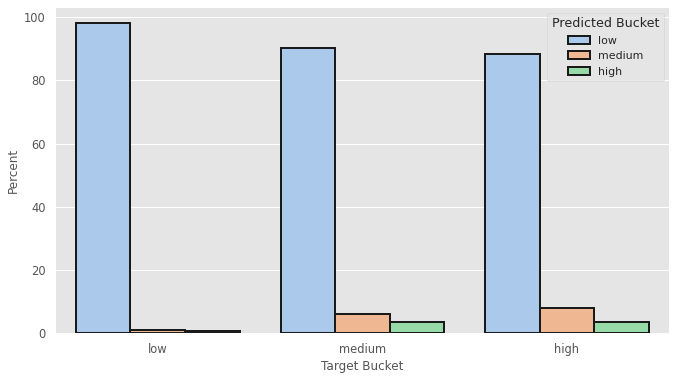

In [27]:
fig, ax = plt.subplots(figsize = (11,6))
sns.barplot(data=aux, 
            x="Target Bucket", 
            y="Percent", 
            hue="Predicted Bucket",
            linewidth=2,
            edgecolor="k",
            order=["low", "medium", "high"],
            hue_order=["low", "medium", "high"],
            palette="pastel",
            ax=ax)

plt.legend(loc="upper right", fontsize=11, title="Predicted Bucket")
plt.savefig("/content/bucket_results.png", format="png")
plt.show()

# **Iteractive Figures**

In [28]:
fig = go.Figure()

fig.add_trace(go.Bar(x=['low', 'medium', 'high'], y=[0.982143, 0.903509, 0.882353], name='predicted low'))
fig.add_trace(go.Bar(x=['low', 'medium', 'high'], y=[0.061404, 0.010714, 0.080882], name='predicted medium'))
fig.add_trace(go.Bar(x=['low', 'medium', 'high'], y=[0.007143, 0.035088, 0.036765], name='predicted high'))
fig.show()